<a href="https://colab.research.google.com/github/myomyint-maung/nlp-assignments/blob/main/05-Sentiment-Analysis/05-Sentiment-Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 08 Feb - Sentiment Analysis

In [1]:
# Import necessary libraries
import torch, torchdata, torchtext
from torch import nn
import time

# Choose computing device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Set SEED for reproducibility
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


### 1. ETL

In [2]:
# Load the Stanford Sentiment Treebank dataset
import pytreebank
sst = pytreebank.load_sst()

In [3]:
# Extract the training, validation and test sets
train  = sst['train']
val    = sst['dev']
test   = sst['test']

len(train), len(val), len(test)

(8544, 1101, 2210)

### 2. EDA

In [4]:
# Check a data sample
for sentiment, text in train[0].to_labeled_lines():
    print(sentiment, text)
    break

3 The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .


In [5]:
# Extract the training, validation and test data
datasets    = [train, val, test]
train_data  = []
val_data    = []
test_data   = []
data        = [train_data, val_data, test_data]

for i in range(len(data)):
  dataset = datasets[i]
  for example in dataset:
    for sentiment, text in example.to_labeled_lines():
      data[i].append((sentiment, text))

len(train_data), len(val_data), len(test_data)

(318582, 41447, 82600)

In [6]:
# Convert the datasets into dataframes
import pandas as pd

train_df  = pd.DataFrame(train_data, columns=["Sentiment", "Text"])
val_df    = pd.DataFrame(val_data, columns=["Sentiment", "Text"])
test_df   = pd.DataFrame(test_data, columns=["Sentiment", "Text"])

In [7]:
# Check the dataframes
print(train_df.head())
print(val_df.head())
print(test_df.head())

   Sentiment                                               Text
0          3  The Rock is destined to be the 21st Century 's...
1          2                                           The Rock
2          2                                                The
3          2                                               Rock
4          4  is destined to be the 21st Century 's new `` C...
   Sentiment                                               Text
0          3  It 's a lovely film with lovely performances b...
1          2                                                 It
2          4  's a lovely film with lovely performances by B...
3          4  's a lovely film with lovely performances by B...
4          2                                                 's
   Sentiment                            Text
0          2  Effective but too-tepid biopic
1          3                   Effective but
2          3                       Effective
3          2                             but
4      

In [8]:
# Check the class labels in the dataframes
print(train_df.Sentiment.value_counts())
print(val_df.Sentiment.value_counts())
print(test_df.Sentiment.value_counts())

2    219788
3     44194
1     34362
4     11993
0      8245
Name: Sentiment, dtype: int64
2    28305
3     5781
1     4613
4     1678
0     1070
Name: Sentiment, dtype: int64
2    56548
3    10998
1     9255
4     3791
0     2008
Name: Sentiment, dtype: int64


**According to the SST paper, the meaning of the class labels are as follows:**
- **'0' is 'very negative';**
- **'1' is 'negative';**
- **'2' is 'neutral';**
- **'3' is 'positive; and**
- **'4' is 'very positive'.**

### 3. Preprocessing

#### 3.1. Tokenization

In [9]:
# Create a tokenizer
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

#### 3.2. Numericalization

In [10]:
# Create vocab out of the training set
from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(data_iter):
    for data in data_iter:
        for _, text in data.to_labeled_lines():
            yield tokenizer(text)
        
vocab = build_vocab_from_iterator(yield_tokens(train),
                                  specials=['<unk>','<pad>','<bos>','<eos>'])

vocab(['<unk>', '<pad>', '<bos>', '<eos>'])

[0, 1, 2, 3]

In [11]:
# Set <unk> as the default index of the vocab
vocab.set_default_index(vocab['<unk>'])

vocab['hahaha']

0

In [12]:
# Create idex2word dictionary
idx2word = vocab.get_itos()

idx2word[0:4]

['<unk>', '<pad>', '<bos>', '<eos>']

In [13]:
# Check the vocab size
len(vocab)

17136

### 4. Embedding

In [14]:
# Load FastText embeddings
from torchtext.vocab import FastText

fast_vectors = FastText(language='simple')

In [15]:
# Select FastText embeddings for the vocab
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)

fast_embedding.shape

torch.Size([17136, 300])

### 5. Preparing Dataloader

In [16]:
# Create a function to collate batches
from torch.utils.data   import DataLoader
from torch.nn.utils.rnn import pad_sequence

text_pipeline  = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

pad_idx = vocab['<pad>']

def collate_batch(batch):
    label_list, text_list, length_list = [], [], []
    for (_label, _text) in batch:
        label_list.append(_label)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        length_list.append(processed_text.size(0))
        
    return torch.tensor(label_list, dtype=torch.int64), \
        pad_sequence(text_list, padding_value=pad_idx, batch_first=True), \
        torch.tensor(length_list, dtype=torch.int64)

In [17]:
# Prepare dataloaders
batch_size = 64

train_loader = DataLoader(train_data, batch_size = batch_size,
                          shuffle=True, collate_fn=collate_batch)

val_loader   = DataLoader(val_data, batch_size = batch_size,
                          shuffle=True, collate_fn=collate_batch)

test_loader  = DataLoader(test_data, batch_size = batch_size,
                          shuffle=True, collate_fn=collate_batch)

In [18]:
# Check a sample batch from the train_loader
for label, text, length in train_loader:
  break

label, text, length

(tensor([4, 2, 3, 2, 2, 3, 1, 4, 2, 4, 2, 0, 2, 2, 4, 3, 2, 2, 2, 2, 2, 1, 2, 2,
         2, 2, 1, 2, 4, 2, 2, 2, 2, 4, 1, 2, 3, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1,
         1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2]),
 tensor([[  163,     1,     1,  ...,     1,     1,     1],
         [   24,     1,     1,  ...,     1,     1,     1],
         [   16,  4723,     1,  ...,     1,     1,     1],
         ...,
         [  346,   797,     8,  ...,     1,     1,     1],
         [ 1344,     1,     1,  ...,     1,     1,     1],
         [    7, 14579,   594,  ...,     1,     1,     1]]),
 tensor([ 1,  1,  2,  3,  1,  6,  1,  1,  1,  3,  1, 12,  5, 13,  5,  1,  1,  1,
          3,  1,  1, 11,  1,  1,  2,  1,  2,  1, 18,  2,  1,  1,  2, 18,  1,  9,
          2,  1, 15,  2,  3,  1,  1,  2,  4,  1,  1,  9, 26,  1,  1,  1,  1,  3,
          1,  1, 14,  1,  4,  5,  3,  4,  1,  6]))

In [19]:
label.shape, text.shape, length.shape

(torch.Size([64]), torch.Size([64, 26]), torch.Size([64]))

In [20]:
# Define the lengths of data loaders
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(val_loader)))
test_loader_length  = len(list(iter(test_loader)))

train_loader_length, val_loader_length, test_loader_length

(4978, 648, 1291)

### 6. Modeling

In [21]:
# Create the LSTM model
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout):
        super().__init__()
        #put padding_idx so asking the embedding layer to ignore padding
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(emb_dim, 
                           hid_dim, 
                           num_layers=num_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hid_dim * 2, output_dim)
        
    def forward(self, text, text_lengths):
        #text = [batch size, seq len]
        embedded = self.embedding(text)
        
        #++ pack sequence ++
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), enforce_sorted=False, batch_first=True)
        
        #embedded = [batch size, seq len, embed dim]
        packed_output, (hn, cn) = self.lstm(packed_embedded)  #if no h0, all zeroes
        
        #++ unpack in case we need to use it ++
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        #output = [batch size, seq len, hidden dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)
        #hn = [batch size, hidden dim * num directions]
        
        return self.fc(hn)

### 7. Training

In [22]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

In [23]:
# Set the parameters for the LSTM model
input_dim  = len(vocab)
hid_dim    = 256
emb_dim    = 300
output_dim = 5

#for biLSTM
num_layers = 2
bidirectional = True
dropout = 0.5

model = LSTM(input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout).to(device)
model.apply(initialize_weights)
model.embedding.weight.data = fast_embedding #**<------applied the fast text embedding as the initial weights

In [24]:
# Print the model's parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

5140800
307200
262144
  1024
  1024
307200
262144
  1024
  1024
524288
262144
  1024
  1024
524288
262144
  1024
  1024
  2560
     5
______
7863109


In [25]:
# Set the hyperparameters for training
import torch.optim as optim

lr=1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [26]:
# Create a function to calculate prediction accuracy
def accuracy(preds, y):
    
    predicted = torch.max(preds.data, 1)[1]
    batch_corr = (predicted == y).sum()
    acc = batch_corr / len(y)
    
    return acc

In [27]:
# Create a function to train the model
def train(model, loader, optimizer, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    
    for i, (label, text, text_length) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions = model(text, text_length).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1
        
        #calculate loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [28]:
# Create a function to evaluate the model
def evaluate(model, loader, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text, text_length) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)

            predictions = model(text, text_length).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [29]:
# Create a function to calculate training time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [30]:
# Create the folder to save models
import os
from os import path

if path.exists('./models') == False:
  os.mkdir('./models')

In [31]:
# Train the model
best_val_loss = float('inf')
num_epochs      = 5

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, train_loader_length)
    val_loss, val_acc = evaluate(model, val_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')   
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')

Epoch: 01 | Time: 1m 9s
	 Train Loss: 0.484 | Train Acc: 80.51%
	 Val. Loss: 0.452 |  Val. Acc: 81.50%
Epoch: 02 | Time: 1m 7s
	 Train Loss: 0.354 | Train Acc: 85.28%
	 Val. Loss: 0.453 |  Val. Acc: 81.95%
Epoch: 03 | Time: 1m 6s
	 Train Loss: 0.313 | Train Acc: 86.89%
	 Val. Loss: 0.480 |  Val. Acc: 80.26%
Epoch: 04 | Time: 1m 8s
	 Train Loss: 0.283 | Train Acc: 88.11%
	 Val. Loss: 0.505 |  Val. Acc: 80.04%
Epoch: 05 | Time: 1m 6s
	 Train Loss: 0.256 | Train Acc: 89.19%
	 Val. Loss: 0.525 |  Val. Acc: 79.26%


### 8. Plotting

Text(0, 0.5, 'loss')

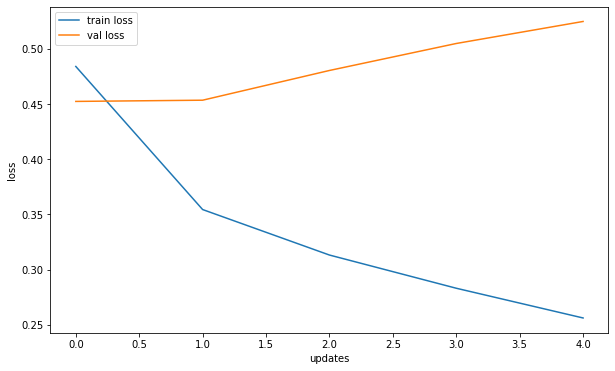

In [32]:
# Plot the losses
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(val_losses, label = 'val loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

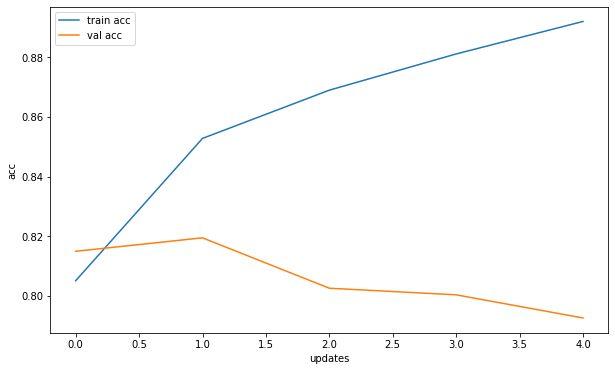

In [33]:
# Plot the accuracies
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(val_accs, label = 'val acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

### 9. Testing

In [34]:
# Calculate the test accuracy
model.load_state_dict(torch.load(save_path))

test_loss, test_acc = evaluate(model, test_loader, criterion, test_loader_length)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.457 | Test Acc: 81.65%


In [35]:
# Test on some random text
test_str = "Google is now falling nonstop.  The price is really bad now."
text = torch.tensor(text_pipeline(test_str)).to(device)
text = text.reshape(1, -1)  #because batch_size is 1
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)

def predict(text, text_length):
    with torch.no_grad():
        output = model(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

predict(text, text_length)

tensor([0], device='cuda:0')

In [36]:
# Test on some negating positive sentence
test_str = "He is hardly intelligent."
text = torch.tensor(text_pipeline(test_str)).to(device)
text = text.reshape(1, -1)  #because batch_size is 1
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)

def predict(text, text_length):
    with torch.no_grad():
        output = model(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

predict(text, text_length)

tensor([1], device='cuda:0')

In [37]:
# Test on some negating negative sentence
test_str = "But, he does not look unhappy."
text = torch.tensor(text_pipeline(test_str)).to(device)
text = text.reshape(1, -1)  #because batch_size is 1
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)

def predict(text, text_length):
    with torch.no_grad():
        output = model(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

predict(text, text_length)

tensor([2], device='cuda:0')